In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [3]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [4]:
# Define the compression function: takes data, spits out compressed summaries
# Should have the form compressor(data, args) -> compressed summaries
# NB: compression should be set-up like a quasi maximum-likelihood estimator
compressor = cosmic_shear.score
compressor_args = [Finv, theta_fiducial, prior_mean, Qinv, Cinv, dCdt, nl, modes]

In [5]:
# The data vector: import or otherwise simulate for testing
data = compressor(cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N), compressor_args)
#data = compressor(simulator(theta_fiducial, simulator_args), compressor_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [ ]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 113s 3ms/step - loss: 32.1724 - val_loss: 16.1905
Epoch 2/30
45000/45000 [==============================] - 71s 2ms/step - loss: 15.9398 - val_loss: 15.4322
Epoch 3/30
45000/45000 [==============================] - 73s 2ms/step - loss: 15.5333 - val_loss: 15.3494
Epoch 4/30
45000/45000 [==============================] - 86s 2ms/step - loss: 15.2014 - val_loss: 15.0117
Epoch 5/30
45000/45000 [==============================] - 201s 4ms/step - loss: 15.0763 - val_loss: 14.6739
Epoch 6/30
45000/45000 [==============================] - 78s 2ms/step - loss: 14.5125 - val_loss: 14.0020
Epoch 7/30
45000/45000 [==============================] - 59s 1ms/step - loss: 13.7700 - val_loss: 13.1427
Epoch 8/30
45000/45000 [==============================] - 58s 1ms/step - loss: 13.0028 - val_loss: 12.5626
Epoch 9/30
45000/45000 [

Saving fish_pretrain_post.pdf


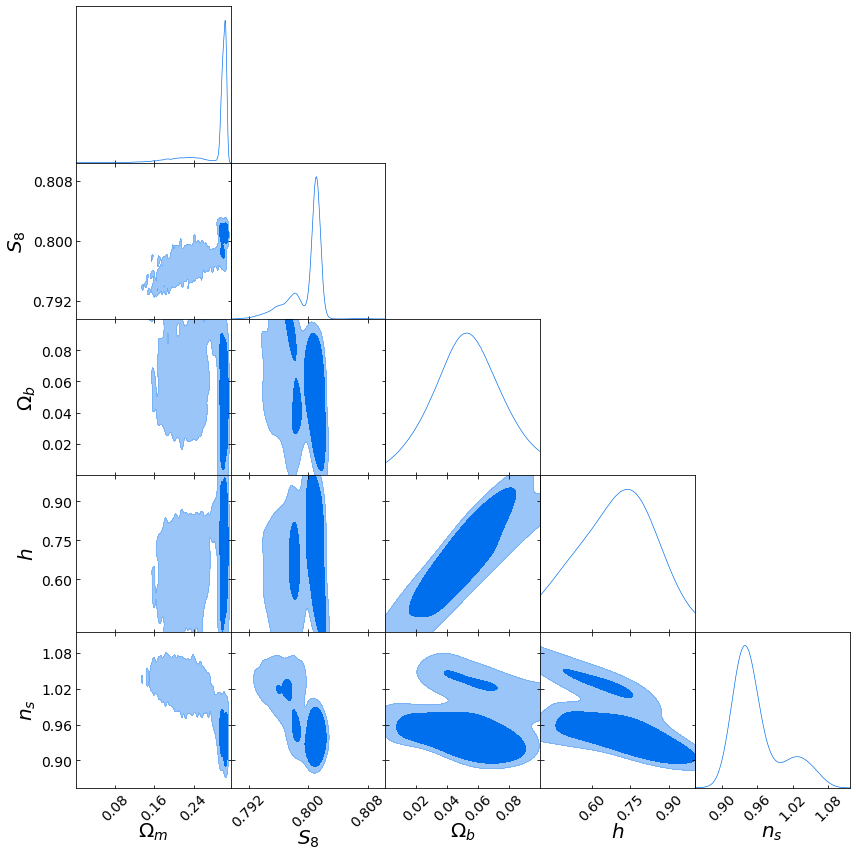

In [20]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=30)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 1ms/step - loss: 19.2196 - val_loss: 19.0707
Epoch 2/100
450/450 [==============================] - 1s 1ms/step - loss: 15.7327 - val_loss: 16.0770
Epoch 3/100
450/450 [==============================] - 1s 1ms/step - loss: 13.7123 - val_loss: 14.4526
Epoch 4/100
450/450 [==============================] - 1s 1ms/step - loss: 12.3472 - val_loss: 13.5663
Epoch 5/100
450/450 [==============================] - 1s 1ms/step - loss: 11.4378 - val_loss: 12.7916
Epoch 6/100
450/450 [==============================] - 1s 1ms/step - loss: 10.7905 - val_loss: 11.9897
Epoch 7/100
450/450 [==============================] - 1s 1ms/step - loss: 10.3065 - val_loss: 11.3080
Epoch 8/100
450/450 [==============================] - 1s 1ms/step - loss: 9.9108 - val_loss: 10.8893
Epoch 9/100
450/450 [==============================] - 1s 1ms/step - loss: 9.6151 - val_loss: 10.6

450/450 [==============================] - 1s 1ms/step - loss: 5.8725 - val_loss: 6.8570
Epoch 81/100
450/450 [==============================] - 1s 1ms/step - loss: 5.8548 - val_loss: 6.8657
Epoch 82/100
450/450 [==============================] - 1s 1ms/step - loss: 5.8327 - val_loss: 6.8605
Epoch 83/100
450/450 [==============================] - 1s 1ms/step - loss: 5.8176 - val_loss: 6.8281
Epoch 84/100
450/450 [==============================] - 1s 1ms/step - loss: 5.7965 - val_loss: 6.8213
Epoch 85/100
450/450 [==============================] - 1s 1ms/step - loss: 5.7795 - val_loss: 6.7883
Epoch 86/100
450/450 [==============================] - 1s 1ms/step - loss: 5.7593 - val_loss: 6.7586
Epoch 87/100
450/450 [==============================] - 1s 1ms/step - loss: 5.7413 - val_loss: 6.7396
Epoch 88/100
450/450 [==============================] - 1s 1ms/step - loss: 5.7208 - val_loss: 6.7628
Epoch 89/100
450/450 [==============================] - 1s 1ms/step - loss: 5.7015 - val_loss: 

Saving seq_train_post_0.pdf


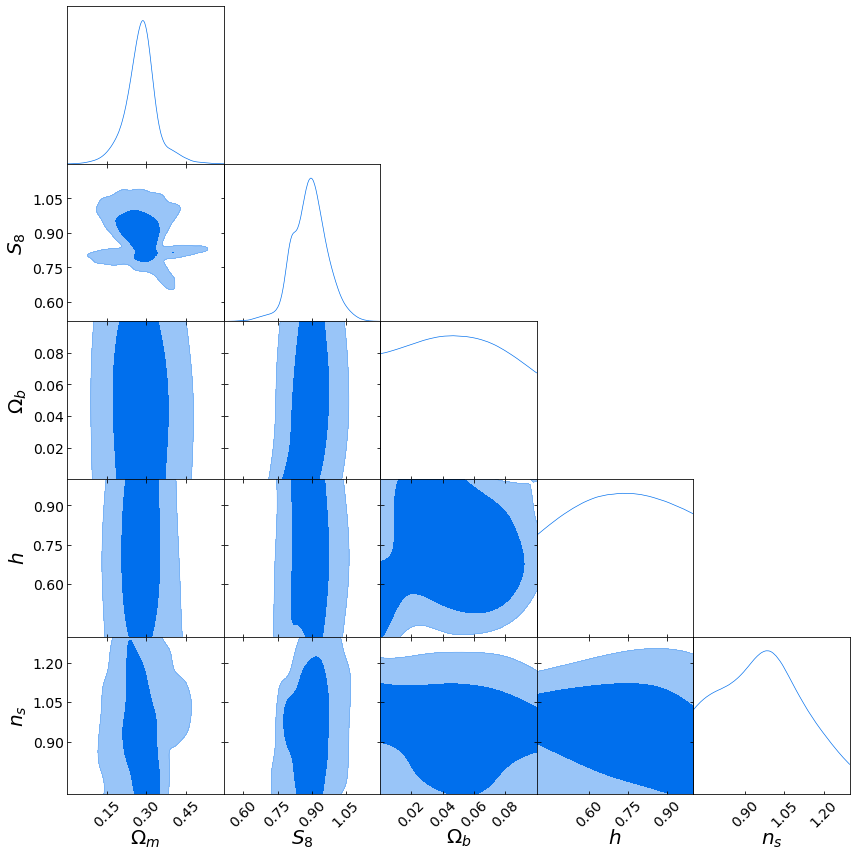

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.09771514 0.79088269 0.04178798 0.48905113 0.96461634] (rank 0)
Simulator returns exception for parameter values: [0.09771514 0.79088269 0.04178798 0.48905113 0.96461634] (rank 0)
Simulator returns exception for parameter values: [0.12770037 0.77640797 0.03471444 0.59028142 0.89515827] (rank 0)
Simulator returns exception for parameter values: [0.12770037 0.77640797 0.03471444 0.59028142 0.89515827] (rank 0)
Simulator returns exception for parameter values: [0.12770037 0.77640797 0.03471444 0.59028142 0.89515827] (rank 0)
Simulator returns exception for parameter values: [0.12770037 0.77640797 0.03471444 0.59028142 0.89515827] (rank 0)
Simulator returns exception for parameter values: [0.12770037 0.77640797 0.03471444 0.59028142 0.89515827] (rank 0)
Simulator returns exception for parameter values: [0.11879294 0.71967638 0.04093138 0.58906937 0.88102164] (rank 0)
S

Simulator returns exception for parameter values: [0.15618677 0.98669456 0.04102733 0.80792598 1.16595683] (rank 0)
Simulator returns exception for parameter values: [0.1223096  1.02924633 0.04846152 0.76119978 1.18659333] (rank 0)
Simulator returns exception for parameter values: [0.16360021 0.93896621 0.0818177  0.99215545 1.12934464] (rank 0)
Simulator returns exception for parameter values: [0.19198988 0.89446552 0.084235   0.99363693 1.09553274] (rank 0)
Simulator returns exception for parameter values: [0.19198988 0.89446552 0.084235   0.99363693 1.09553274] (rank 0)
Simulator returns exception for parameter values: [0.19198988 0.89446552 0.084235   0.99363693 1.09553274] (rank 0)
Simulator returns exception for parameter values: [0.19198988 0.89446552 0.084235   0.99363693 1.09553274] (rank 0)
Simulator returns exception for parameter values: [0.19335753 0.89457817 0.08264747 0.99122116 1.09247097] (rank 0)
Simulator returns exception for parameter values: [0.19335753 0.89457817

Epoch 19/100
900/900 [==============================] - 1s 1ms/step - loss: 9.0452 - val_loss: 47.3251
Epoch 20/100
900/900 [==============================] - 1s 1ms/step - loss: 9.0365 - val_loss: 47.6043
Epoch 21/100
900/900 [==============================] - 1s 1ms/step - loss: 9.0242 - val_loss: 47.8301
Sampling approximate posterior...
Done.
Saving seq_train_post_1.pdf


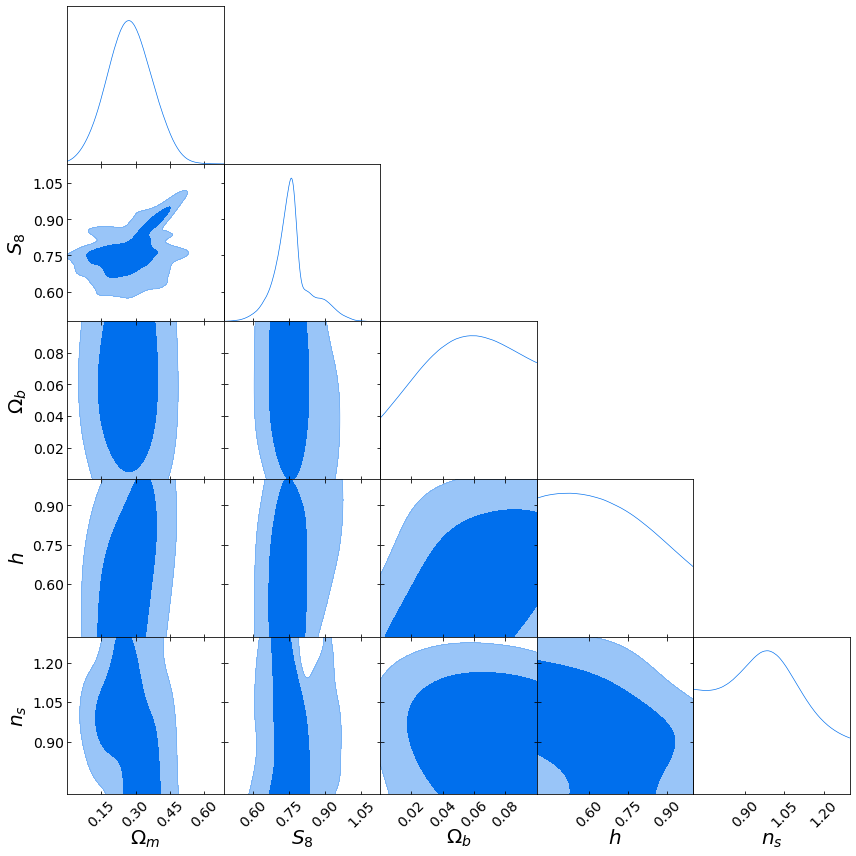

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.14767391 0.71231154 0.04570469 0.40893383 1.24495866] (rank 0)
Simulator returns exception for parameter values: [0.06403401 0.78254207 0.08757173 0.64927566 1.05017173] (rank 0)
Simulator returns exception for parameter values: [0.06403401 0.78254207 0.08757173 0.64927566 1.05017173] (rank 0)


In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, simulator_args=simulator_args, compressor_args=compressor_args)

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


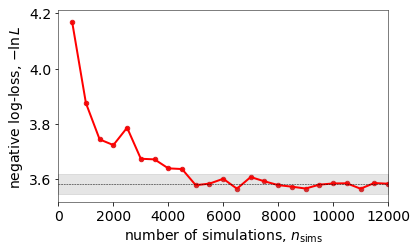

In [30]:
plt.close()
columnwidth = 15 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})

# Trace plot of the loss as a function of the number of simulations
plt.scatter(n_sims, loss_trace, s = 20)
plt.plot(n_sims, loss_trace, color = 'red', lw = 2)
plt.fill_between(mdn.n_sim_trace, loss_trace[-1]*0.99*np.ones(len(mdn.n_sim_trace)), loss_trace[-1]*1.01*np.ones(len(mdn.n_sim_trace)), color = 'grey', alpha = 0.2 )
plt.xlim(0, mdn.n_sim_trace[-1])
plt.axhline(loss_trace[-1], color = 'black', ls = '--')
plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log-loss, $-\mathrm{ln}\,U$')
plt.show()